In [17]:
%run /home/grg/git/alfa/nilearn-helper.py
%matplotlib inline
%run /home/grg/git/alfa/roicollect.py

This collect the values from \*\_stats.csv files, i.e. values that have been extracted from ROI manually drawn in MNI space.
The bad thing with this is that the ROI is defined in a reference space. This is subject to individual registration errors.

{1: 'left_occip', 2: 'left_temporal', 3: 'left_temporal2', 4: 'right_perihorn', 5: 'left_occip2', 6: 'left_perihorn', 7: 'left_wm', 8: 'right_occip', 9: 'right_temporal', 10: 'left_insula'}
Standard deviation of label left_occip: 3.61479441412e-05
Model used for correction: roi ~ 1 + C(apo) + gender + educyears + ventricles
Standard deviation after correction for covariates: 3.45873917507e-05
Region: left_occip - Fitting order: 1 - Formula: roi ~ 1 + age
Standard deviation of label left_temporal: 4.05365557781e-05
Model used for correction: roi ~ 1 + C(apo) + gender + educyears + ventricles
Standard deviation after correction for covariates: 3.81164034065e-05
Region: left_temporal - Fitting order: 1 - Formula: roi ~ 1 + age
Standard deviation of label left_temporal2: 4.87319860333e-05
Model used for correction: roi ~ 1 + C(apo) + gender + educyears + ventricles
Standard deviation after correction for covariates: 4.72349416503e-05
Region: left_temporal2 - Fitting order: 1 - Formula: roi

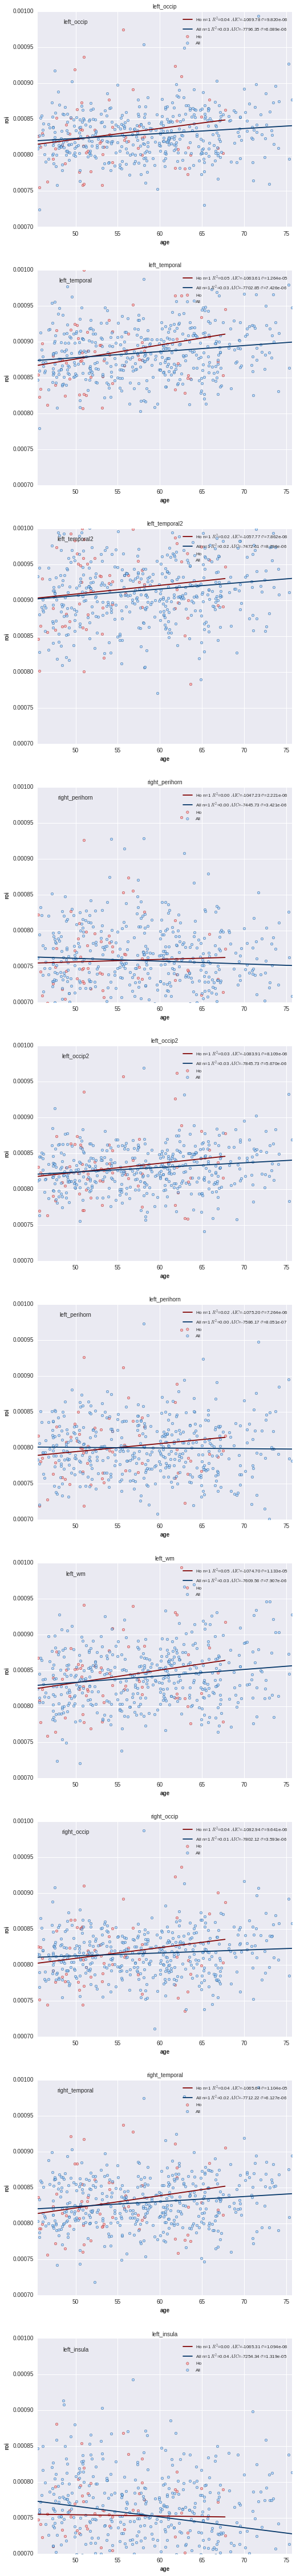

In [27]:
regions = range(1,11)
data = pd.read_excel('/tmp/covariates.xls')
data['subject'] = data.index
data = data.sort_values(['apo', 'subject'])
src = '/tmp/roivalues_csf.5/'
filepattern = '*_stats.csv'
csvfiles = glob(osp.join(src, filepattern))
subjects = [string.atoi(e.split('/')[-1].split('_')[0]) for e in csvfiles]

to_remove = [10551, 10397, 11383, 13083, 10701, 21092] # failed DARTEL subjects

# remove wrong subjects
data = data[~data['subject'].isin(to_remove)]
for e in to_remove:
    s = subjects.index(e)
    subjects.pop(s)
    csvfiles.pop(s)
    
plot_regions(data, regions, csvfiles, subjects, groups=['HO','All'], ylim=[0.0007,0.001])

In [28]:
import plotly
#plotly.init_notebook_mode()

def plotly_region(roilabel):
    to_remove = [55166, 66159, 77068, 10182, 13059, 66019, 66264, 77024, 77263,
            10846, 66026, 66039, 66131, 66368, 77027, 77047]
    data = collect_data()
    roivalues = collect_roivalues(roilabel)
    #data = data[data['apo']==0]
    df = data.join(roivalues)
    df['subject'] = df.index
    #df = df.drop(to_remove)
    
    
    import plotly.plotly as py
    import plotly.graph_objs as go

    #data = [trace]

    # Plot and embed in ipython notebook!
    #

    trace = go.Scatter(
        x = df['age'],
        y = df['roi'],

        marker=dict(
            size='4',
            color = df['apo'], #set color equal to a variable
            colorscale='Jet',
            showscale=True),
        text = df['subject'],
        mode = 'markers'
    )

    data = [trace]

    # Plot and embed in ipython notebook!
    py.iplot(data)
    # or plot with: plot_url = py.plot(data, filename='basic-line')

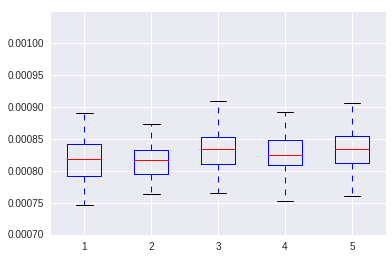

In [28]:
roivalues = collect_roivalues(1, csvfiles, subjects)
df = data.join(roivalues)
groups_sub = get_groups(df, groups_names = ['apoe44', 'apoe34', 'apoe24', 'apoe33', 'apoe23'])
roi_sub = [e['roi'] for e in groups_sub]
bx = plt.boxplot(roi_sub)
plt.show()

0.00101153
W:0.9520 p:0.0001 139 subjects between 0.000730593 and 0.00101153


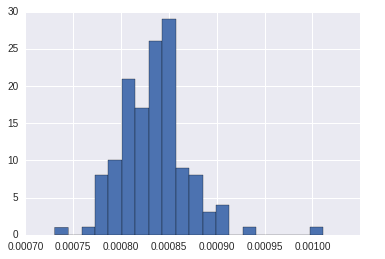

In [33]:
from scipy import stats
print roi_sub[2].max()
for x in roi_sub[2:3]:
    plt.hist(x, bins=20)
    print 'W:%.4f p:%.4f'%stats.shapiro(x), len(x), 'subjects between', min(x), 'and', max(x)

In [36]:
for i in range(1,9):
    roivalues = collect_roivalues(i, csvfiles, subjects)
    df = data.join(roivalues)
    groups_sub = get_groups(df, groups_names = ['apoe44', 'apoe34', 'apoe24', 'apoe33', 'apoe23'])
    roi_sub = [e['roi'] for e in groups_sub]
    print df[df['roi']>0.001]['subject']

55778    55778
55388    55388
Name: subject, dtype: int64
11436    11436
55778    55778
10096    10096
11711    11711
13306    13306
55388    55388
Name: subject, dtype: int64
11407    11407
11803    11803
12484    12484
77068    77068
11436    11436
11137    11137
12327    12327
44094    44094
55297    55297
55778    55778
66498    66498
77263    77263
10099    10099
10593    10593
10988    10988
11254    11254
44147    44147
11711    11711
Name: subject, dtype: int64
Series([], Name: subject, dtype: int64)
55778    55778
Name: subject, dtype: int64
Series([], Name: subject, dtype: int64)
11803    11803
13306    13306
Name: subject, dtype: int64
Series([], Name: subject, dtype: int64)


In [43]:
j = json.load(open('/home/grg/spm/data/apoe_groups.json'))
j['55388']

4